In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import models, optimizers, regularizers
import cv2
import os
import numpy as np

In [2]:
# Definir el generador de imágenes de entrenamiento con aumento de datos
train_datagen = ImageDataGenerator(rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

In [3]:
# Definir el generador de imágenes de validación sin aumento de datos
valid_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
                                                    target_size=(200, 200),
                                                    batch_size=32,
                                                    class_mode="binary")

test_generator = valid_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test",
                                                         target_size=(200, 200),
                                                         batch_size=32,
                                                         class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Creando el modelo
model = models.Sequential()

model.add(Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [6]:
# Ajustar hiperparámetros y entrenar modelo
learning_rate = 0.0001
dropout_rate = 0.5
batch_size = 32
epochs = 50

In [7]:
# Definiendo los callbacks
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)

In [8]:
# Compilando el modelo
model.compile(optimizer=optimizers.Adam(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
# Entrenando el modelo
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 4.8358 - accuracy: 0.7481
Epoch 1: val_loss improved from inf to 1.93592, saving model to best_model.h5
163/163 [==============================] - 152s 898ms/step - loss: 4.8358 - accuracy: 0.7481 - val_loss: 1.9359 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.8113
Epoch 2: val_loss improved from 1.93592 to 0.80866, saving model to best_model.h5
163/163 [==============================] - 111s 680ms/step - loss: 1.1582 - accuracy: 0.8113 - val_loss: 0.8087 - val_accuracy: 0.8207 - lr: 1.0000e-04
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.8499
Epoch 3: val_loss improved from 0.80866 to 0.58671, saving model to best_model.h5
163/163 [==============================] - 114s 699ms/step - loss: 0.6470 - accuracy: 0.8499 - val_loss: 0.5867 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 4/50
163

In [10]:
# Evaluar rendimiento del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 8s 375ms/step - loss: 0.3287 - accuracy: 0.8702
Test accuracy: 0.870192289352417


In [11]:
# Obtener las predicciones del modelo sobre los datos de prueba
y_pred = model.predict(test_generator)
# Convertir las predicciones a clases binarias (0 o 1)
y_pred = np.round(y_pred)
# Obtener las etiquetas reales de los datos de prueba
y_true = test_generator.classes

20/20 [==============================] - 7s 337ms/step


In [12]:
# Calcular la matriz de confusión
confusion = confusion_matrix(y_true, y_pred)
# Obtener la sensibilidad y especificidad a partir de la matriz de confusión
tn, fp, fn, tp = confusion.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)
print("Sensibilidad: {:.2f}%".format(sensibilidad*100))
print("Especificidad: {:.2f}%".format(especificidad*100))

Sensibilidad: 58.21%
Especificidad: 35.04%


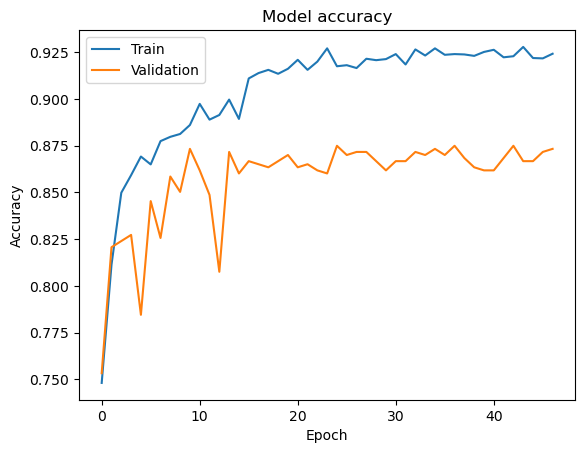

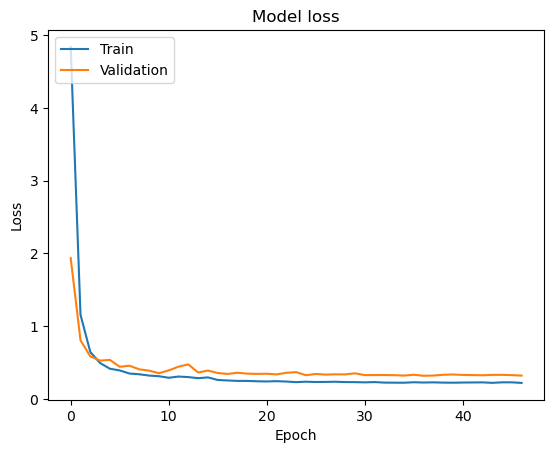

In [13]:
# Visualizar curvas de aprendizaje
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()